# 0. Intro

First of all, I think it is quite important to explain what exactly I am going to achieve in this demo, explain why it is even worth considering, and propose my own way of solving the problem.

We are going to talk about the so-called method “Chain of Thoughts” proposed by the Google Brain Team in 2022 and its modifications. In this experiment, we will talk only about the maths word problems, keep this in mind.
First of all, what is a “Chain of Thoughts”? It is a familiar process to every human since not many of us can solve the task without thinking of the intermediate reasoning and conclusions, coming straight to the answer. Let’s think of the example:

* Problem: Beth bakes 4, 2 dozen batches of cookies in a week. If these 
cookies are shared amongst 16 people equally, how many cookies does each person consume?
* Solution: Beth bakes 4 2 dozen batches of cookies for a total of 4*2 = <<4*2=8>>8 dozen cookies. There are 12 cookies in a dozen and she makes 8 dozen cookies for a total of 12*8 = <<12*8=96>>96 cookies. She splits the 96 cookies equally amongst 16 people so they each eat 96/16 = <<96/16=6>>6 cookies
* Final Answer: 6

The whole process of solving this task seems natural for you and me, so why do not we try the same, but for the model, and give her not only the answer as an example but also the solution?

Turned out, it is a thing, although it improves mostly really large models and confuses smaller ones. The performance on GPT-3 with 175B parameters improved from 15.6% accuracy with a standard prompt to 46.9% only by using CoT on the GSM8K corpus.

But there is more: with ensembling, the scores are getting even higher. The idea might be quite simple by now, but anyway, the idea needs to be voiced: by running the model several times and choosing the most popular answer, the scores might be improved even more! 

# 1. The model. DEMO

In this demo I will try CoT method on the BLOOM model, compare it to the GPT-3 results (since these two have relatively same number of parameters), try ensembling method and propose future studies.

First, install the [*local part of the*] model. It is approximately 8GB out of 352GB, and usually takes 3 minutes. Sometimes there are not enough peers to use the distributed model, so we will try to run it on our own machine.

In [1]:
!pip install -q petals

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 113.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 113.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 115.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In this part we are going to test the model itself: examine some obvious drawbacks and prepare to deal with them. The real experiments come later.

In [2]:
import torch
from transformers import BloomTokenizerFast 
from petals import DistributedBloomForCausalLM

MODEL_NAME = "bigscience/bloomz-petals"
tokenizer = BloomTokenizerFast.from_pretrained(MODEL_NAME)
model = DistributedBloomForCausalLM.from_pretrained(MODEL_NAME)
model = model.cuda()

Downloading:   0%|          | 0.00/319 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/637 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/7.19G [00:00<?, ?B/s]

In [48]:
TOP_K = 100
TEMPERATURE = 0.2

Firstly, some constants, the model, and a hand-testing on a few examples. There are a few different ways on communication with the model: some of them do not work completely, some of them are too pricey for us in terms of limited computing power.

In [4]:
text = """Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Solution: Natalia sold 48/2 = 24 clips in May.\nNatalia sold 48+24 = 72 clips altogether in April and May
Answer: 72

Question: Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?
Solution: Weng earns 12/60 = 0.2 per minute.\nWorking 50 minutes, she earned 0.2 x 50 = 10
Answer: 10

Question: Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?
Solution: In the beginning, Betty has only 100 / 2 = 50.\nBetty's grandparents gave her 15 * 2 = 30.\nThis means, Betty needs 100 - 50 - 30 - 15 = 5 more.
Answer: 5

Question: Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?
Solution: """

# First variant of generating:

Here we are trying to generate all the phrase in ones:

In [18]:
inputs = tokenizer(text, return_tensors="pt")["input_ids"].cuda()
outputs = model.generate(inputs, temperature=TEMPERATURE, do_sample=True, top_k=TOP_K, max_new_tokens=120)
bloom_answer_tokens = tokenizer.decode(outputs[0])

print(bloom_answer_tokens)

Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Solution: Natalia sold 48/2 = 24 clips in May.
Natalia sold 48+24 = 72 clips altogether in April and May
Answer: 72

Question: Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?
Solution: Weng earns 12/60 = 0.2 per minute.
Working 50 minutes, she earned 0.2 x 50 = 10
Answer: 10

Question: Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?
Solution: In the beginning, Betty has only 100 / 2 = 50.
Betty's grandparents gave her 15 * 2 = 30.
This means, Betty needs 100 - 50 - 30 - 15 = 5 more.
Answer: 5

Question: Julie is reading a 120-page book. Yesterday, s

### So, what have we seen on a first glance within first two days of testing:


**This is the most common situation by the end of the day. It just does not connecting to the servers.**

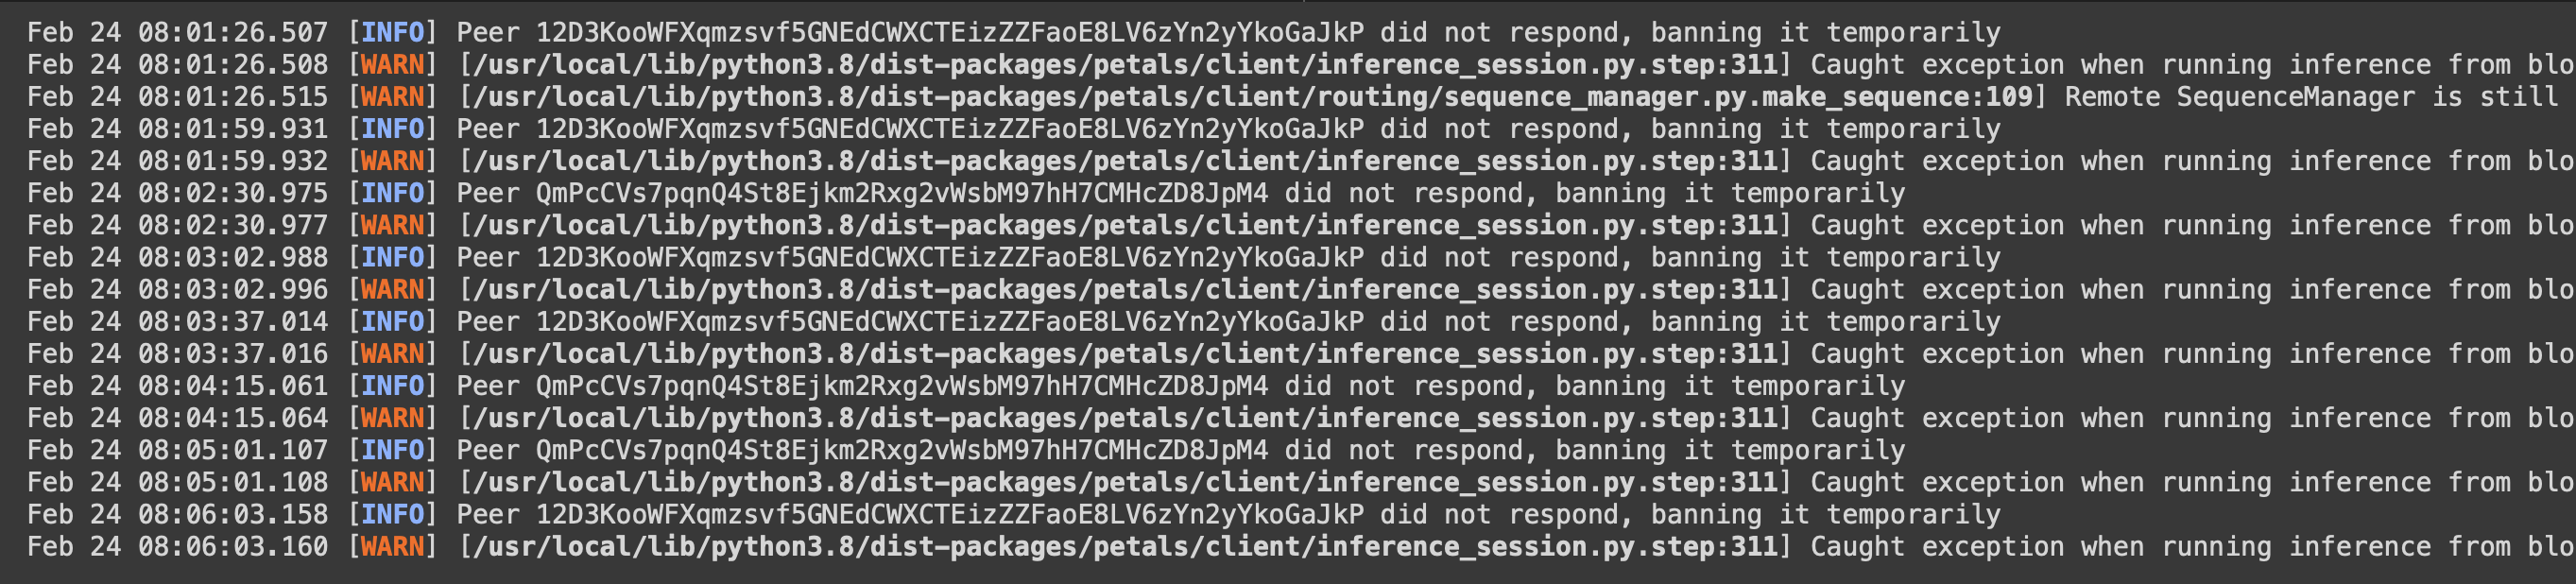

I am going to keep this output here to show the major model's drawback: it is not popular enough to work as it supposed to work. There are not enough peers, and I am trying to work with it while the server load is not high. The high servers' load is not helpful either: colab peers like me are not that powerful to make the job done and take part in sharing model's parts.

If we keep doing that way, we will spend more than 2K minutes / 33 hours evaluating only train part of the dataset. Of course, we might test only on 100 examples, and spend about 3-5 hours evaluating, but I do not find this amount sufficient. Bu we will see, still.


---


The speed of the generation process is decent, although it is much slower than GPT-3 with HF's API, but waiting for a response from the server kills the other advantages.

In the further work I am going to either keep fighting with this model, or use something else with HF API or try and use FlexGen that I have not tested yet.

Sad, but this is the point we are at.

P.S.: I am not going to test the results on the smaller BLOOM model, because:
* according to the original paper, CoT method only more confuses the smaller models, making the results not better, but worse
* from what I have seen so far (when the model has finally responded me), CoT does not significantly improve the bigger one, so I do not see the point where we are impoving on the smaller ones. I am going to insert some screenshots to support my point:

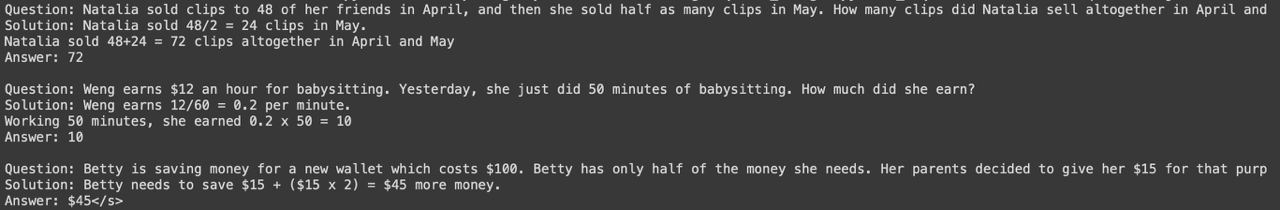

The prompt is the first example and the second question. The solution and the answer were generated by the model. This example is just completely wrong from the solution to the answer itself.

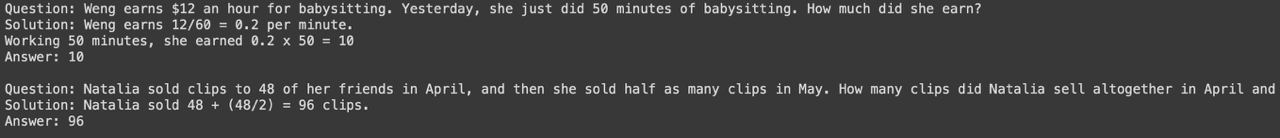

The second experiment idea was just to swap the tasks, since the example of the first one might be easier than the test question. I was right at some point, so here we see only computational mistake, not the logic one, which is nice.

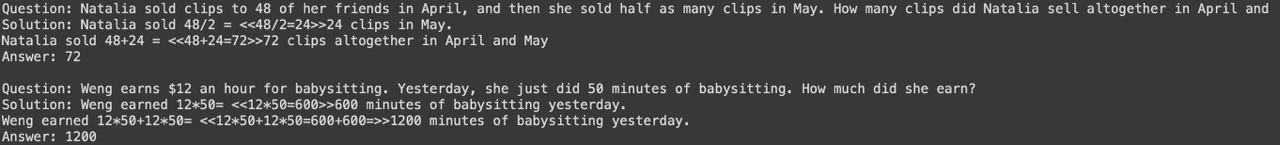

The idea of the last one was to add a bit more examples (By the way, I have reached 4 examples in the prompt before the actual question and still got something barely coherent). In this example just everything is wrong again: from the solution to the answer.

### Let's continue with the second variant of generating:

In this approach we will try to generate the answer one-by-one or interactive generating. I see it more convenient: we do not need to adjust $max\_new\_tokens$ number and just stop after we got an answer. Otherwise the model sometimes decides to generate her own tasks which is a little bit excessive.

In [5]:
import re

In [28]:
text = """Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Solution: Natalia sold 48/2 = 24 clips in May.\nNatalia sold 48+24 = 72 clips altogether in April and May
Answer: 72

Question: Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?
Solution: Weng earns 12/60 = 0.2 per minute.\nWorking 50 minutes, she earned 0.2 x 50 = 10
Answer: 10

Question: Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?
Solution: In the beginning, Betty has only 100 / 2 = 50.\nBetty's grandparents gave her 15 * 2 = 30.\nThis means, Betty needs 100 - 50 - 30 - 15 = 5 more.
Answer: 5

Question: Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?
Solution: """

In [51]:
ans = ''
with model.inference_session(max_length=1500) as sess:

    cnt = 0

    prompt = text
    prefix = tokenizer(prompt, return_tensors="pt")["input_ids"].cuda()

    print(prompt, end="", flush=True)

    while True:
        outputs = model.generate(
                prefix, max_new_tokens = 1, do_sample = True, top_p=0.9, temperature=0.75, session = sess
            )
        outputs = tokenizer.decode(outputs[0, -1:])
        print(outputs, end="", flush=True)
        ans += outputs

        if "Answer" in outputs:
            cnt += 1
        if cnt > 0:
            cnt += 1

        if cnt == 4:
            break
        prefix = None

Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Solution: Natalia sold 48/2 = 24 clips in May.
Natalia sold 48+24 = 72 clips altogether in April and May
Answer: 72

Question: Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?
Solution: Weng earns 12/60 = 0.2 per minute.
Working 50 minutes, she earned 0.2 x 50 = 10
Answer: 10

Question: Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?
Solution: In the beginning, Betty has only 100 / 2 = 50.
Betty's grandparents gave her 15 * 2 = 30.
This means, Betty needs 100 - 50 - 30 - 15 = 5 more.
Answer: 5

Question: Julie is reading a 120-page book. Yesterday, s

✨It does not work at all✨

In [47]:
ans

' read tomorrow - 40</s> online live'

# HF API

This approach does not work completely, since the model seems to be either broken or out of reach for some reason. In the other cases it might be a decent way to do our job. This part is here just to show what else can be done.

P.S.: the demo on the Hugging Face page does not work either.

In [ ]:
"""
import json
import requests
API_URL = "https://api-inference.huggingface.co/models/bigscience/bloomz-petals"
API_TOKEN = %your token%
headers = {"Authorization": f"Bearer {API_TOKEN}"}
def query(payload):
    data = json.dumps(payload)
    response = requests.request("POST", API_URL, headers=headers, data=data)
    return json.loads(response.content.decode("utf-8"))
data = query(text)
#"""

In [ ]:
#data

{'error': 'Model bigscience/bloomz-petals is currently loading',
 'estimated_time': 20.0}

# Conclusion

By the end of the day, I am mentally tired of this model, so my review is pretty simple and short. Which is probably not enough, but I am sick of it... And I would regret if I keep this to myself.

In my opinion, it is a pretty stupid model in general. I have tried different prompts with 176B model (the biggest one), and even though it is comparable with GPT-3 by its size. Sometimes model even cannot follow the pattern and keeps generating something indistictable. The CoT almost does not contribute to the results, since the model is bad itself.

It does not work correctly, so I do not want to push myself further with it.